# 데이터 불러오기

In [1]:
# 현재 경로 확인 및 MINI3 폴더 절대경로 지정
import os
os.getcwd()
os.chdir('C:\\Users\\pmj03\\likelion\\과제\\MINI project3')

In [12]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import koreanize_matplotlib #한글폰트
import seaborn as sns
import folium

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# RFM분석 데이터는 희연님 데이터로!
df = pd.read_parquet('./희연data(user_session, category_id없는 10월분 전체 데이터).parquet')

In [3]:
df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id
1,2019-10-01 00:00:00 UTC,1,3900821,appliances.environment.water_heater,aqua,33.200001,554748717
2,2019-10-01 00:00:01 UTC,1,17200506,furniture.living_room.sofa,None,543.099976,519107250
3,2019-10-01 00:00:01 UTC,1,1307067,computers.notebook,lenovo,251.740005,550050854
4,2019-10-01 00:00:04 UTC,1,1004237,electronics.smartphone,apple,1081.979980,535871217
5,2019-10-01 00:00:05 UTC,1,1480613,computers.desktop,pulser,908.619995,512742880


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28933155 entries, 1 to 42448762
Data columns (total 7 columns):
 #   Column         Dtype   
---  ------         -----   
 0   event_time     category
 1   event_type     uint8   
 2   product_id     uint32  
 3   category_code  object  
 4   brand          object  
 5   price          float32 
 6   user_id        uint32  
dtypes: category(1), float32(1), object(2), uint32(2), uint8(1)
memory usage: 1.2+ GB


In [5]:
# 구매데이터만 따로 추출하기
df_purchase = df.loc[df['event_type'] == 4]

In [6]:
# 중복값 제거
df_purchase.drop_duplicates()
df_purchase.shape

(569424, 7)

In [7]:
# datetime 형태로 변환하기
df_purchase['event_time']=pd.to_datetime(df_purchase['event_time']).dt.tz_convert(None)

In [13]:
# 최근 거래 기준일을 만들기 위해 날짜를 더해줌
last_timestamp = df_purchase['event_time'].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-11-01 23:59:16')

In [14]:
# RFM 값을 정의합니다.
# Recency : 최근 거래 기준일(last_timestamp)과 고객별 최근 구매한 날짜(x.max())와 차이값
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액
rfm = df_purchase.groupby(by='user_id').agg({"event_time" : lambda x : (last_timestamp - x.max()).days,
                                                 'event_type' : 'count',
                                                 'price' : 'sum'})
rfm

,event_time,event_type,price
user_id,,,
303160429,19,1,340.589996
340041246,18,1,339.700012
384989212,14,1,41.439999
401021311,11,1,231.639999
403013066,14,2,807.160034
...,...,...,...
566265448,1,1,592.010010
566267483,1,2,30.740000
566270060,1,2,147.419998


In [16]:
rfm.columns = ['Recency','Frequency','Monetary']
rfm.head(3)

,Recency,Frequency,Monetary
user_id,,,
303160429,19,1,340.589996
340041246,18,1,339.700012
384989212,14,1,41.439999


In [17]:
rfm['Recency'].describe()

count    272071.000000
mean         14.646372
std           8.710487
min           1.000000
25%           7.000000
50%          14.000000
75%          22.000000
max          31.000000
Name: Recency, dtype: float64

<Figure size 1000x600 with 0 Axes>

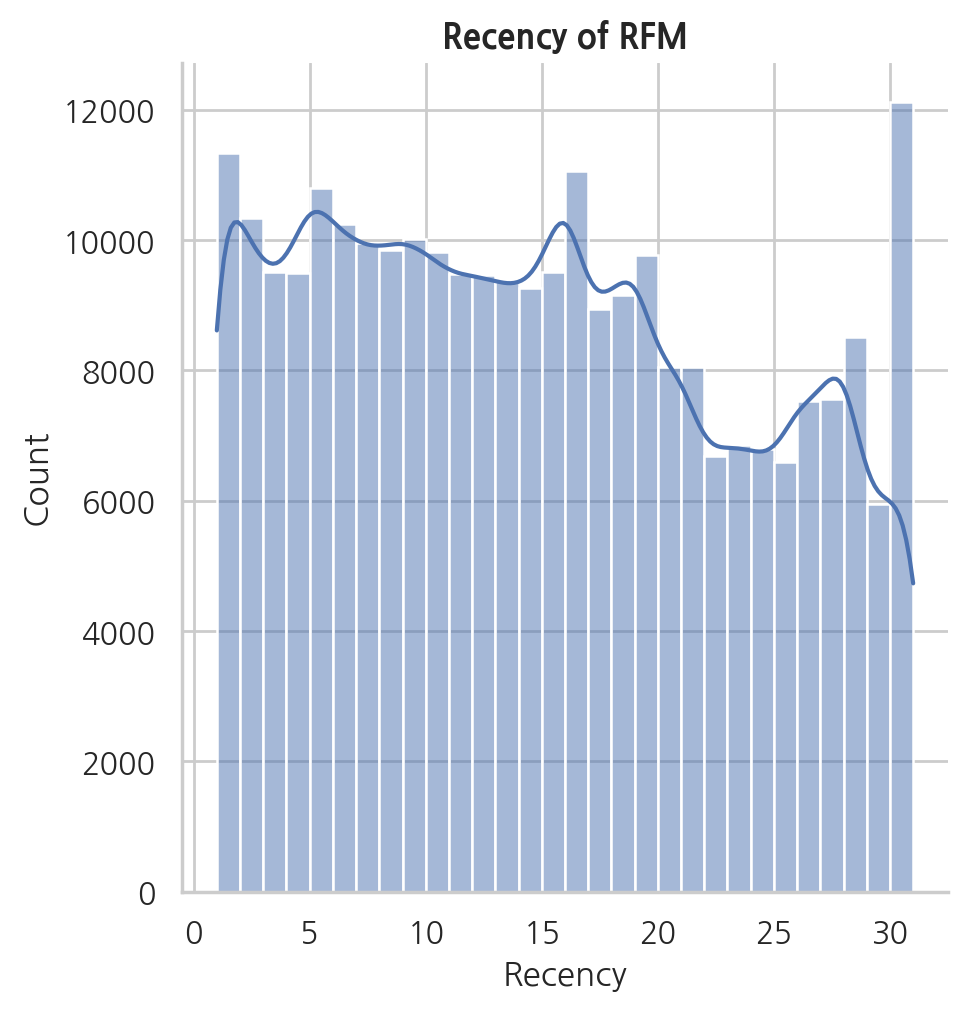

In [18]:
plt.figure(figsize=(10,6))
sns.displot(rfm['Recency'],bins=30 , kde= True)
plt.title("Recency of RFM" , fontweight = 'bold')
plt.show()

In [19]:
rfm['Frequency'].describe()

count    272071.000000
mean          2.092924
std           3.619229
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         322.000000
Name: Frequency, dtype: float64

<Figure size 1000x600 with 0 Axes>

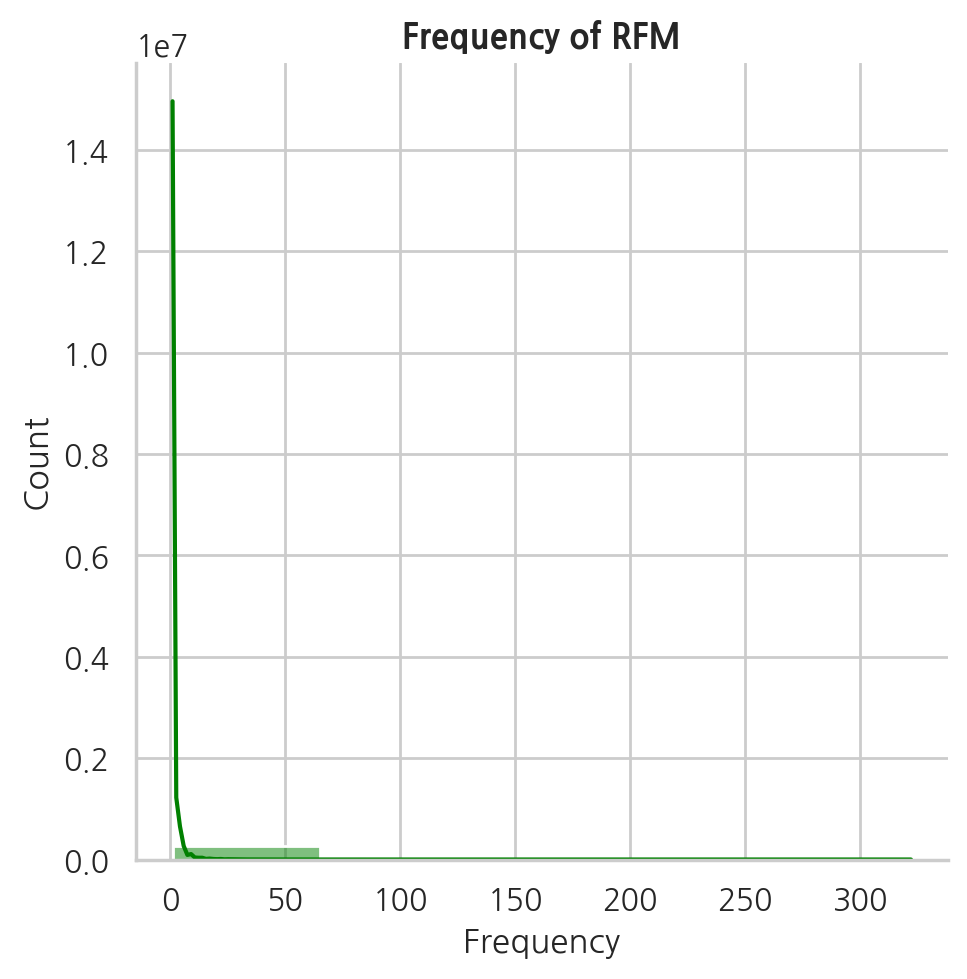

In [21]:
plt.figure(figsize=(10,6))
sns.displot(rfm['Frequency'],bins=5 , kde= True , color ='green')
plt.title("Frequency of RFM" , fontweight = 'bold')
plt.show()

In [22]:
rfm['Monetary'].describe()

count    272071.000000
mean        760.950684
std        2265.115479
min           0.880000
25%         141.860001
50%         285.399994
75%         730.454987
max      265569.531250
Name: Monetary, dtype: float64

<Figure size 1000x600 with 0 Axes>

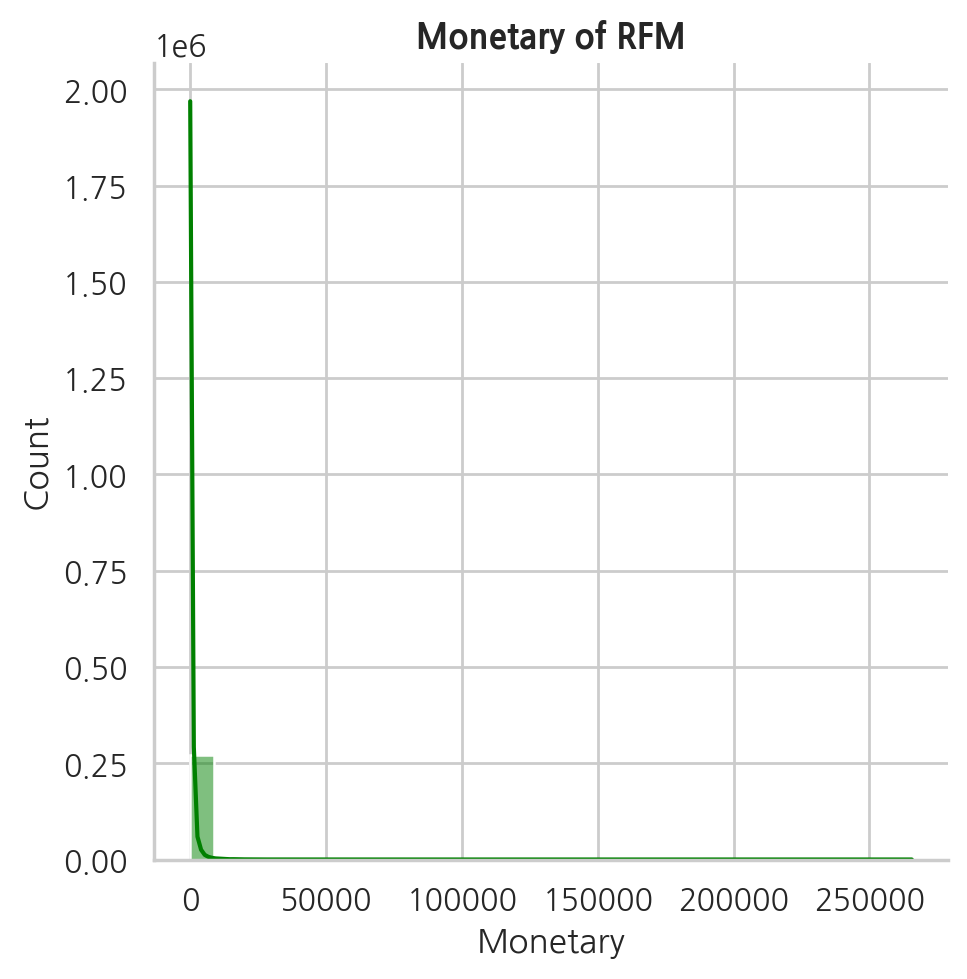

In [23]:
plt.figure(figsize=(10,6))
sns.displot(rfm['Monetary'],bins=30 , kde= True , color ='green')
plt.title("Monetary of RFM" , fontweight = 'bold')
plt.show()

## RFM Segmentation

In [24]:
[min(rfm['Frequency'])-1, 1, 3, max(rfm['Frequency'])]

[0, 1, 3, 322]

In [26]:
f_labels

[1, 2, 3, 4, 5]

In [27]:
bins

[0, 1, 3, 322]

In [25]:
# scoring 기법 : RFM 요인을 각각 5등급으로 등간격으로 분류
r_labels = list(range(5, 0, -1))
f_labels = list(range(1, 6))
m_labels = list(range(1, 6))
cut_size = 5

In [29]:
r_cut = pd.qcut(rfm["Recency"],cut_size, labels= r_labels)
f_cut = pd.qcut(rfm["Frequency"].rank(method='first'),cut_size, labels= f_labels)
m_cut = pd.qcut(rfm["Monetary"],cut_size, labels= m_labels)

In [30]:
rfm = rfm.assign(R = r_cut, F = f_cut, M = m_cut)
rfm

,Recency,Frequency,Monetary,R,F,M
user_id,,,,,,
303160429,19,1,340.589996,2,1,3
340041246,18,1,339.700012,2,1,3
384989212,14,1,41.439999,3,1,1
401021311,11,1,231.639999,4,1,3
403013066,14,2,807.160034,3,4,4
...,...,...,...,...,...,...
566265448,1,1,592.010010,5,4,4
566267483,1,2,30.740000,5,5,1
566270060,1,2,147.419998,5,5,2


## RFM segment

In [31]:
rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

In [32]:
rfm["RFM_score"] = rfm[["R","F","M"]].sum(axis = 1)

<AxesSubplot:xlabel='RFM_segment', ylabel='RFM_score'>

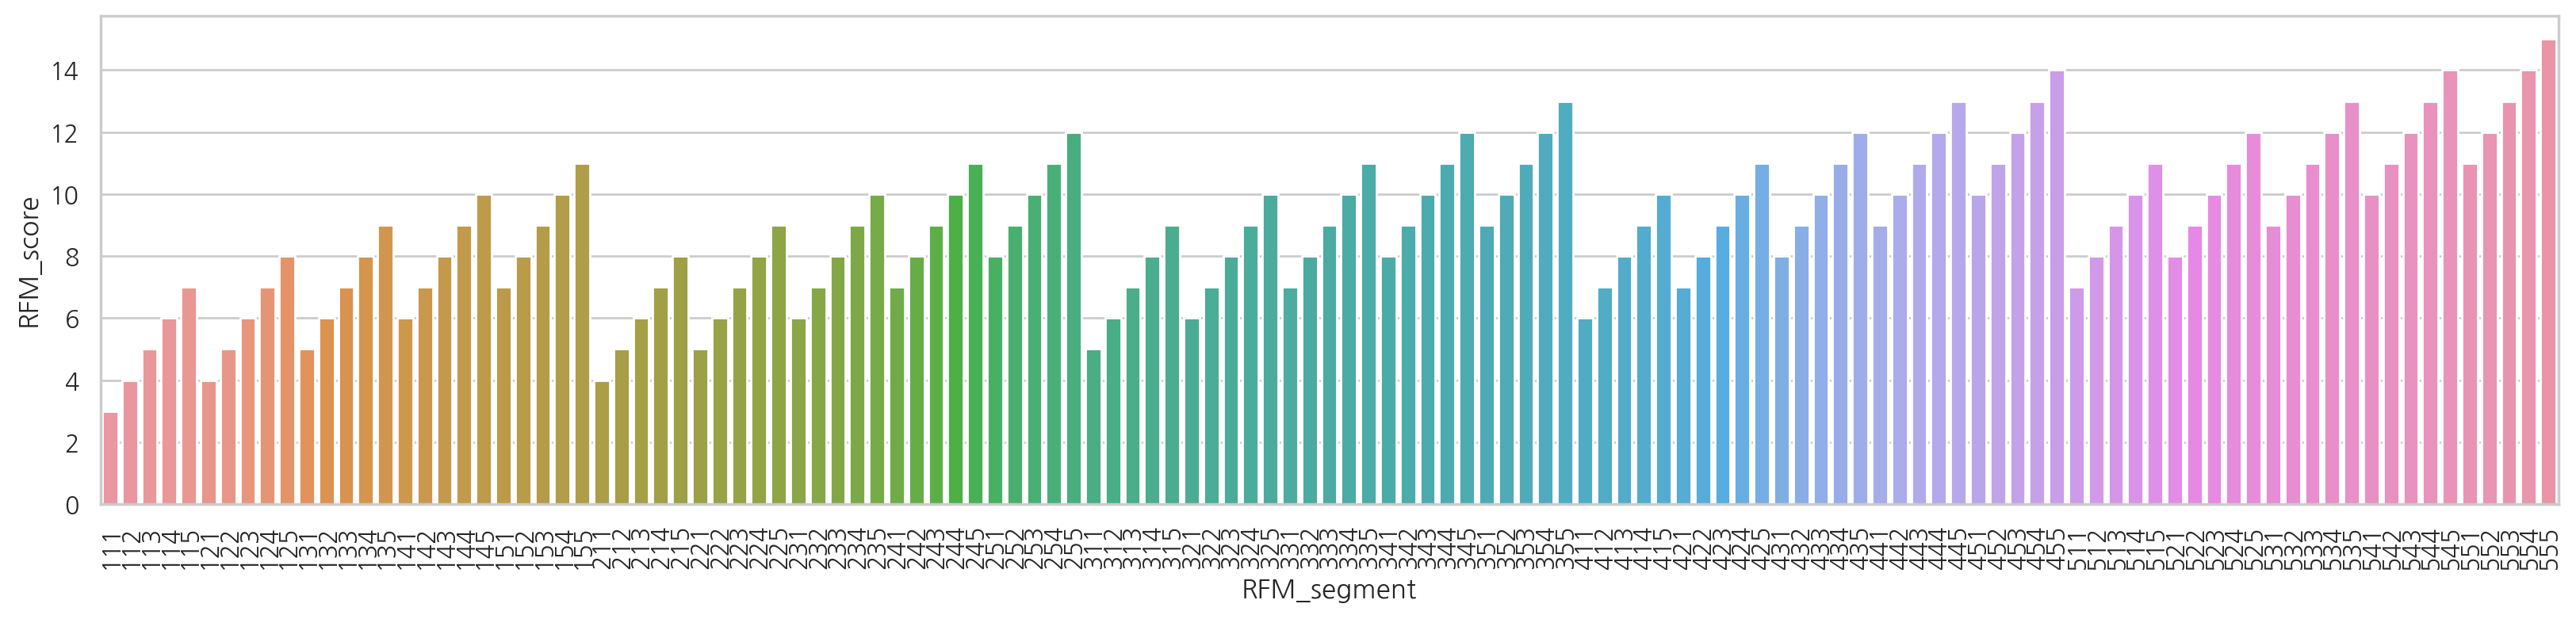

In [33]:
%matplotlib inline 
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values("RFM_segment"),x="RFM_segment",y="RFM_score")

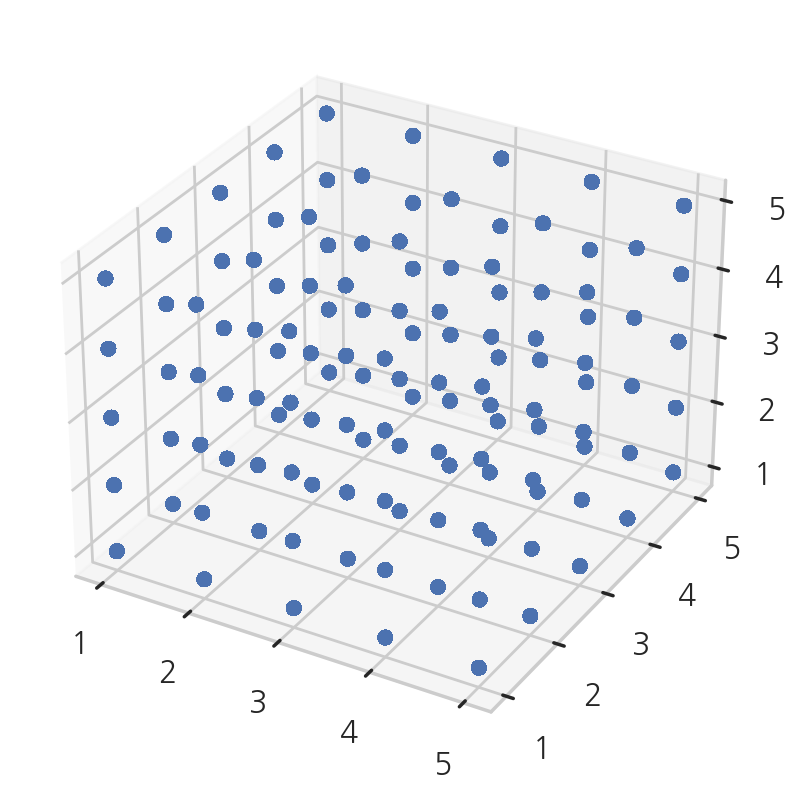

In [34]:
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["R"],rfm["F"],rfm["M"])

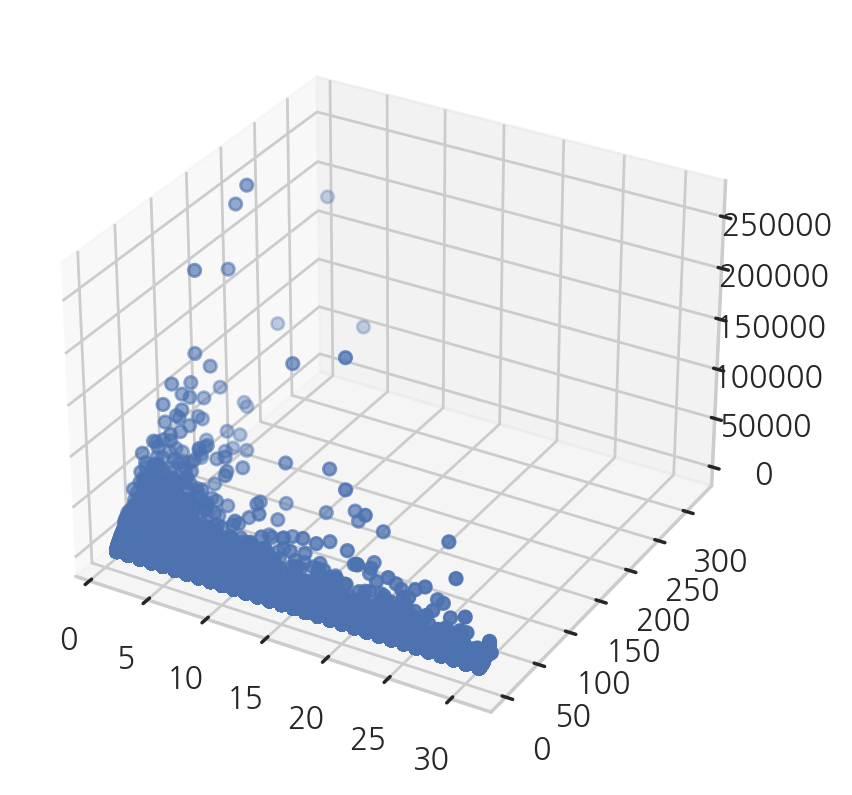

In [36]:
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["Recency"],rfm["Frequency"],rfm["Monetary"])

## 고객 등급 나누기

In [37]:
# qcut 을 통해 3단계로 "silver", "gold", "platinum" 고객군을 나누기
rfm["RFM_class"] = pd.qcut(rfm['RFM_score'],3,labels=['silver','gold','platinum'])

In [38]:
# "RFM_class" 별로 그룹화 하고 "RFM_score" 의 describe 값을 구합니다.
rfm.groupby("RFM_class")["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,93181.0,5.765875,1.169065,3.0,5.0,6.0,7.0,7.0
gold,89580.0,8.939306,0.814331,8.0,8.0,9.0,10.0,10.0
platinum,89310.0,12.665457,1.387455,11.0,11.0,12.0,14.0,15.0


<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

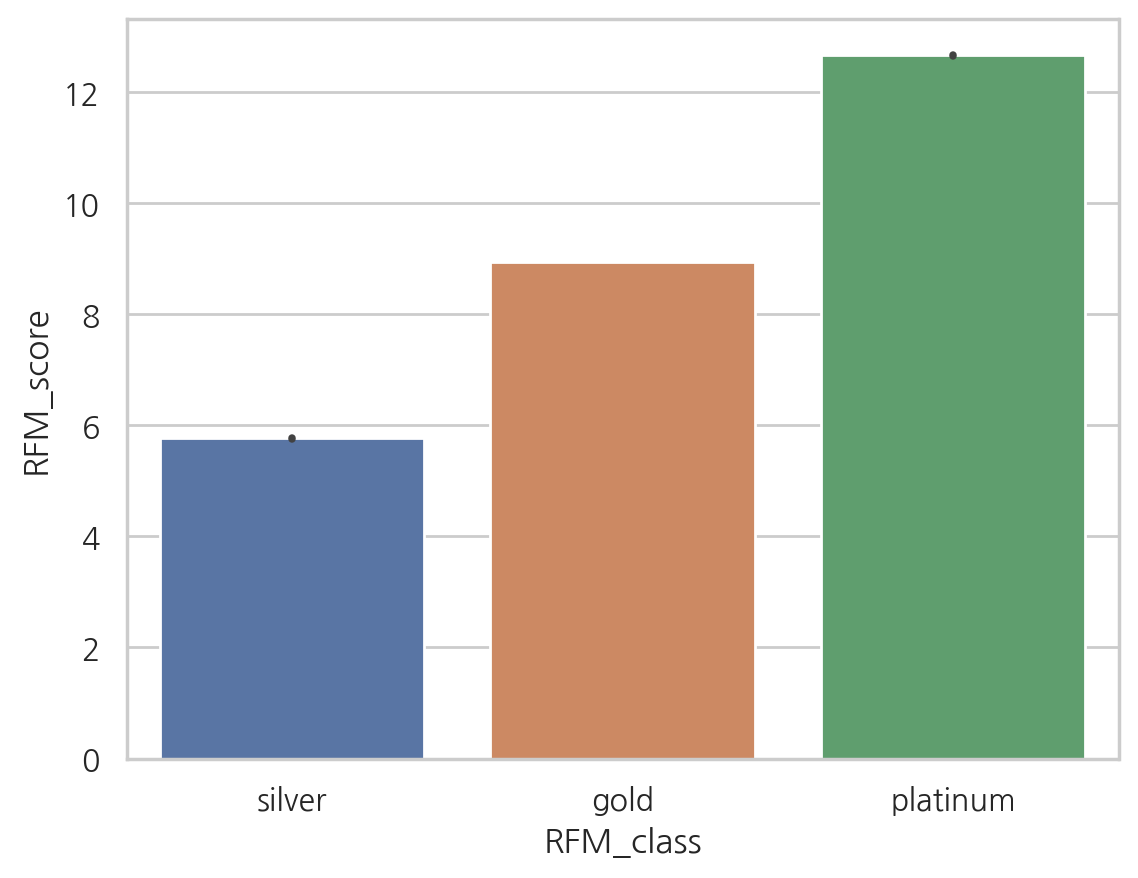

In [39]:
# barplot으로 RFM_class 별 평균 RFM_score 나타냅니다.
sns.barplot(data=rfm, x="RFM_class", y="RFM_score")

<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

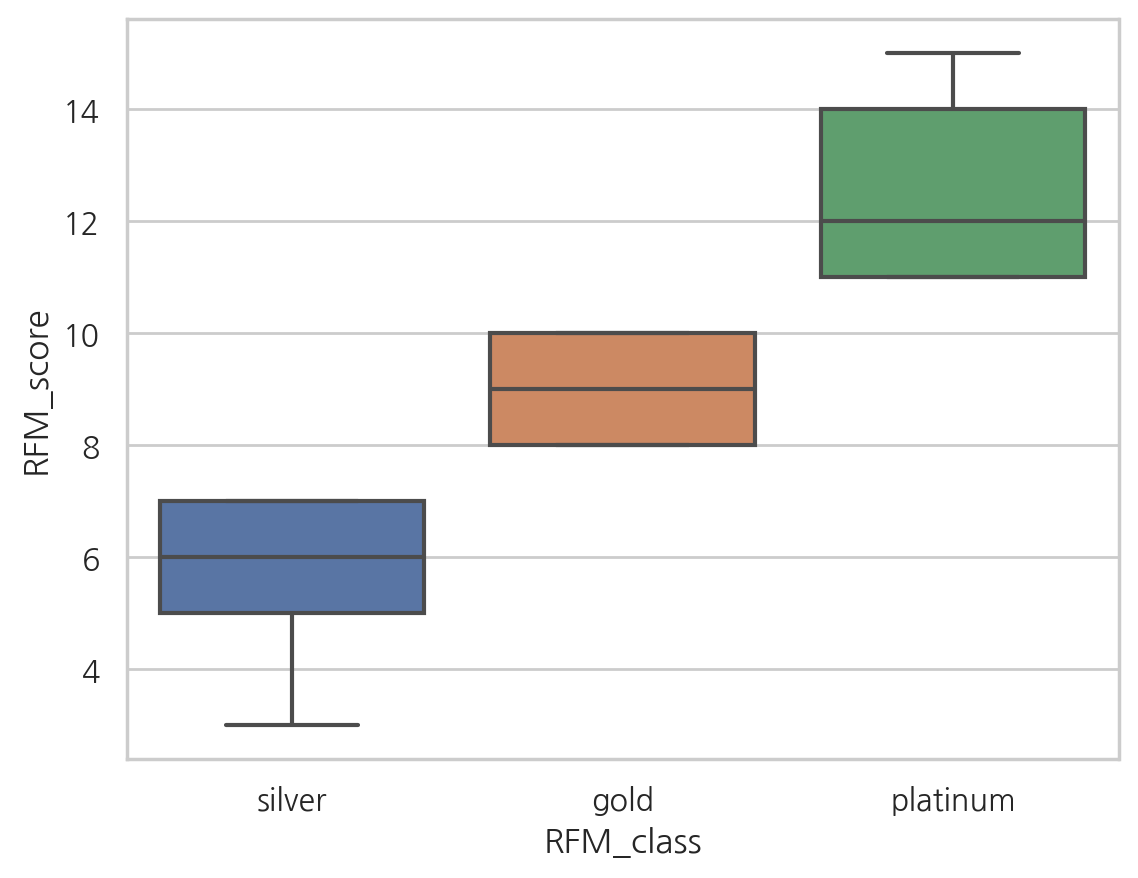

In [40]:
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score")